In [37]:
import numpy as np
import numba


# Negative Momentum?
- https://danieltakeshi.github.io/2017/12/18/on-the-momentum-sign-flipping-for-hamiltonian-monte-carlo/
- https://stats.stackexchange.com/questions/314620/for-hamiltonian-monte-carlo-why-does-negating-the-momentum-variables-result-in
- " There are partial momenta resampling schemes, from the original schemes of Horowitz to more recent "Extra Chance" or "Generalized" schemes, where the negation is of critical importance to the validity of the algorithm "

# multimodal

https://discourse.mc-stan.org/t/handling-multimodality-in-hmc-stan-tempering-nuts/31841/2

# -- 1D Test ----

In [38]:
import numpy as np
class GaussianMultimodal1d:

    def __init__(self, mu, std):
        assert len(mu) == len(std), "mu and std must have the same length"
        self.mu = mu
        self.std = std
        self.n_modes = len(self.mu)
        
        self.weights = [1.0 / self.n_modes] * self.n_modes # Assuming equal weights for simplicity

    def normal_distribution(self, x, mu, std):
        return 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((x - mu) / std) ** 2)

    def pdf(self, x):
        out = sum(weight * self.normal_distribution(x, mu, std) for weight, mu, std in zip(self.weights, self.mu, self.std))
        return out

    def log_pdf(self, x):
        return np.log(self.pdf(x))

    def gradient_log_pdf(self, x):
        if self.n_modes == 1:
            return -(x - self.mu[0]) / self.std[0] ** 2
        else:
            numerator = sum(weight * self.normal_distribution(x, mu, std) * (-(x - mu) / std ** 2)
                            for weight, mu, std in zip(self.weights, self.mu, self.std))
            denominator = self.pdf(x)
            return numerator / denominator
        
    def dVdx(self, x):
        return -self.gradient_log_pdf(x)

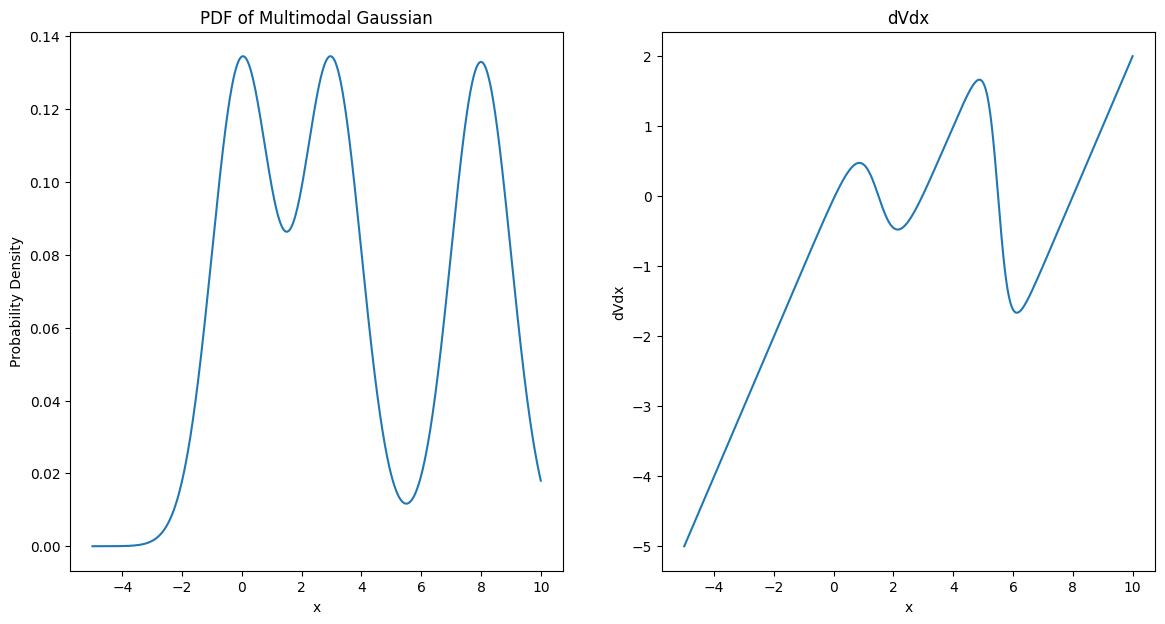

In [39]:

mu = [0, 3,  8]  # Means for two modes
std = [1,1 ,1]  # Standard deviations for two modes
gm1d = GaussianMultimodal1d(mu, std)

x = np.linspace(-5, 10, 1000)
pdf_values = np.array([gm1d.pdf(xi) for xi in x])
grad_dVdx = np.array([gm1d.dVdx(xi) for xi in x])

# Plotting for visual inspection
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(x, pdf_values, label='PDF')
plt.title('PDF of Multimodal Gaussian')
plt.xlabel('x')
plt.ylabel('Probability Density')

plt.subplot(1, 2, 2)
plt.plot(x, grad_dVdx, label='dVdx')
plt.title('dVdx')
plt.xlabel('x')
plt.ylabel('dVdx')

plt.show()

In [42]:

def leapfrog_1d(dVdx, x, v, h, N):
    """
    dVdx - gradient of the potential energy wrt position (parameter), a function
    x - position (parameter), scalar (float)
    v - velocity, scalar (float)
    h - step length, scalar (float)
    N - number of steps, integer
    """

    trace_v = [v]
    trace_x = [x]

    # Update velocity by half step
    v = v - (h/2) * dVdx(x)
    
    for _ in range(N-1): 
        x = x + h * v  # Update position by a full step
        v = v - h * dVdx(x)  # Update velocity by a full step
        trace_v.append(v)
        trace_x.append(x)

    # Final update of position by a full step and velocity by half step
    x = x + h * v
    v = v - (h/2) * dVdx(x)
    
    trace_v.append(v)
    trace_x.append(x)

    trace_v, trace_x = np.array(trace_v), np.array(trace_x)

    return x, v, trace_x, trace_v


def hmc_1d(target_distribution, initial_state, iterations=10_000, step_size=0.1, n_steps=10):
    samples = [initial_state]
    accept_or_not = []
    trace_x_all = []  # Will store lists of x values for each accepted orbit
    trace_v_all = []  # Will store lists of v values for each accepted orbit

    dVdx = target_distribution.dVdx # Gradient of the log PDF

    for i in range(iterations):
        if i%1000 == 0:
            print(f'Current iteration: {i}')

        x0 = samples[-1]
        v0 = np.random.normal()

        # Perform the leapfrog integration
        x_star, v_star, trace_x, trace_v = leapfrog_1d(dVdx, x0, v0, step_size, n_steps)

        # Metropolis-Hastings step
        m0 = -target_distribution.log_pdf(x0) + 0.5 * v0**2
        m_star = -target_distribution.log_pdf(x_star) + 0.5 * v_star**2
        accept_prob = np.exp(m0 - m_star)

        if np.random.uniform() < accept_prob:
            samples.append(x_star)
            accept_or_not.append(True)  # Accepted
            trace_x_all.append(trace_x)
            trace_v_all.append(trace_v)
        else:
            samples.append(x0)
            accept_or_not.append(False)  # Not accepted

    return samples, trace_x_all, trace_v_all, accept_or_not

# Instantiate the target distribution
mu = [0, 3,  8]  # Means for two modes
std = [1,1 ,1]  # Standard deviations for two modes
target_distribution = GaussianMultimodal1d(mu, std)

# Perform HMC sampling
initial_state = 0.0
samples, trace_x_all, trace_v_all, accept_or_not = hmc_1d(target_distribution, initial_state, iterations=100000, step_size=0.1, n_steps=10)


Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 10000
Current iteration: 11000
Current iteration: 12000
Current iteration: 13000
Current iteration: 14000
Current iteration: 15000
Current iteration: 16000
Current iteration: 17000
Current iteration: 18000
Current iteration: 19000
Current iteration: 20000
Current iteration: 21000
Current iteration: 22000
Current iteration: 23000
Current iteration: 24000
Current iteration: 25000
Current iteration: 26000
Current iteration: 27000
Current iteration: 28000
Current iteration: 29000
Current iteration: 30000
Current iteration: 31000
Current iteration: 32000
Current iteration: 33000
Current iteration: 34000
Current iteration: 35000
Current iteration: 36000
Current iteration: 37000
Current iteration: 38000
Current iteration: 39000
Current itera

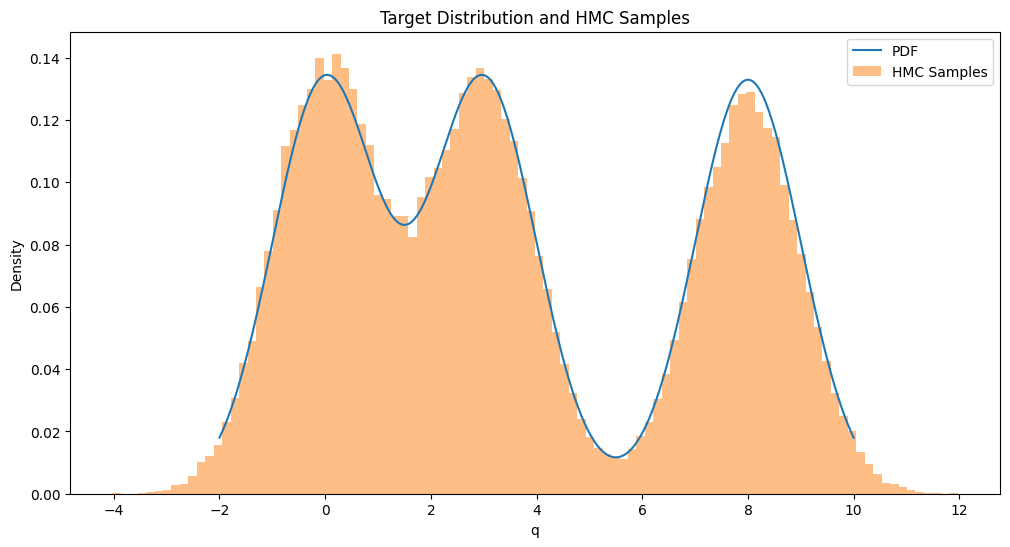

In [50]:
# Plot the target distribution and a histogram of the samples
x_values = np.linspace(-2, 10, 400)
pdf_values = np.vectorize(target_distribution.pdf)(x_values)

plt.figure(figsize=(12, 6))
plt.plot(x_values, pdf_values, label='PDF')
plt.hist(samples, bins=100, density=True, alpha=0.5, label='HMC Samples')
plt.legend()
plt.title('Target Distribution and HMC Samples')
plt.xlabel('q')
plt.ylabel('Density')
plt.show()


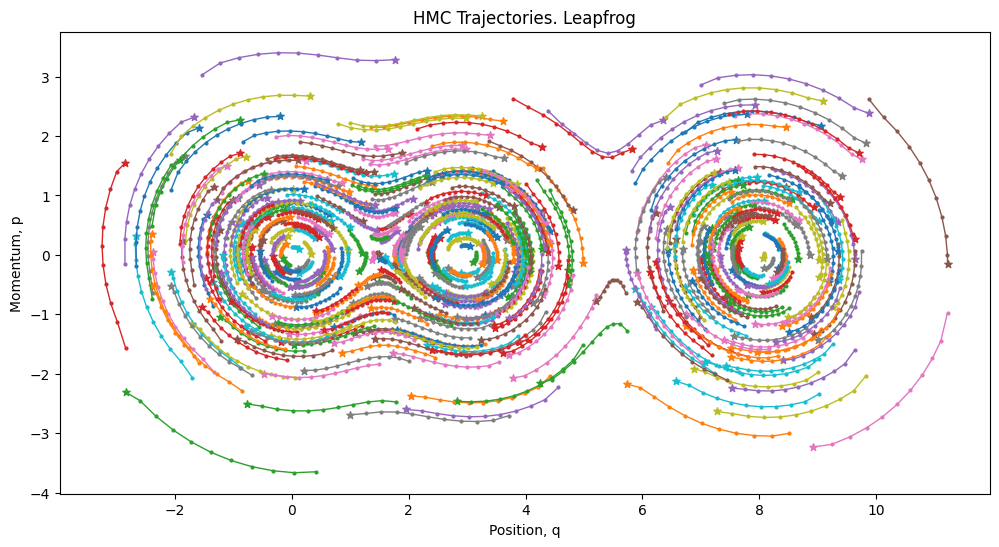

In [52]:

start_i = 1000
max_num = 500
if not max_num or max_num > len(trace_x_all):
    max_num = len(trace_x_all)


# Plotting orbits with the updated structure
plt.figure(figsize=(12, 6))
for trace_x, trace_v in zip(trace_x_all[start_i:start_i+max_num], trace_v_all[start_i:start_i+max_num]):
    plt.plot(trace_x, trace_v, '-o', markersize=2, linewidth=1)
    plt.scatter(trace_x[-1], trace_v[-1], s=30, marker='*')
plt.xlabel('Position, q')
plt.ylabel('Momentum, p')
plt.title('HMC Trajectories. Leapfrog')
plt.show()

# Multivariate

In [53]:
import numpy as np
import matplotlib.pyplot as plt

class GaussianMultimodalND:

    def __init__(self, mus, sigmas):
        assert len(mus) == len(sigmas), "mus and sigmas must have the same length"
        self.mus = mus  # List of mean vectors
        self.sigmas = sigmas  # List of covariance matrices
        self.n_modes = len(self.mus)
        
        self.weights = [1.0 / self.n_modes] * self.n_modes  # Assuming equal weights for simplicity

    def normal_distribution(self, x, mu, sigma):
        d = len(mu)
        sigma_det = np.linalg.det(sigma)
        sigma_inv = np.linalg.inv(sigma)
        norm_const = 1.0 / (np.power((2 * np.pi), float(d) / 2) * np.sqrt(sigma_det))
        x_mu = np.array(x - mu)
        result = np.exp(-0.5 * (x_mu.T.dot(sigma_inv).dot(x_mu)))
        return norm_const * result

    def pdf(self, x):
        return sum(weight * self.normal_distribution(x, mu, sigma) 
                   for weight, mu, sigma in zip(self.weights, self.mus, self.sigmas))

    def log_pdf(self, x):
        return np.log(self.pdf(x))

    def gradient_log_pdf(self, x):
        if self.n_modes == 1:
            sigma_inv = np.linalg.inv(self.sigmas[0])
            return -sigma_inv.dot(x - self.mus[0])
        else:
            numerator = sum(weight * self.normal_distribution(x, mu, sigma) * -np.linalg.inv(sigma).dot(x - mu)
                            for weight, mu, sigma in zip(self.weights, self.mus, self.sigmas))
            denominator = self.pdf(x)
            return numerator / denominator
        
    def dVdx(self, x):
        return -self.gradient_log_pdf(x)
    

    def marginalized_pdf(self, x, dims):
        """
        Compute the marginalized PDF over the specified dimensions.
        
        Args:
        - x: The values for the dimensions of interest.
        - dims: The indices of the dimensions of interest.
        
        Returns:
        - The PDF value after marginalizing over dimensions not in dims.
        """
        marginal_mus = [mu[dims] for mu in self.mus]
        marginal_sigmas = [sigma[np.ix_(dims, dims)] for sigma in self.sigmas]

        return sum(weight * self.normal_distribution(x, mu, sigma) 
                   for weight, mu, sigma in zip(self.weights, marginal_mus, marginal_sigmas))


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Example initialization
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]  # Mean vectors for three modes
sigmas = [np.eye(2), np.eye(2), np.eye(2)]  # Covariance matrices
gmnd = GaussianMultimodalND(mus, sigmas)

NameError: name 'GaussianMultimodalND' is not defined

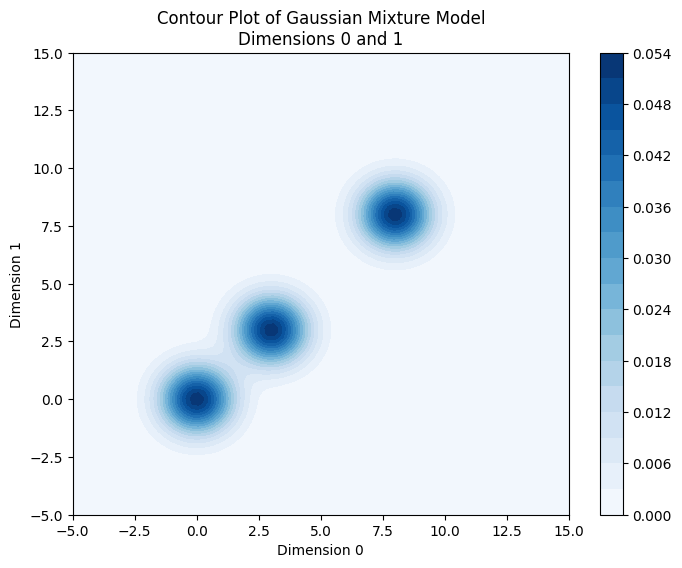

In [13]:

def plot_contour_for_two_dims(gmnd, dim1, dim2, x_range, y_range, resolution=100):
    """
    Plot a contour plot for two selected dimensions of the multivariate Gaussian mixture model.
    
    Args:
    - gmnd: An instance of GaussianMultimodalND.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Prepare an array for evaluating the PDF
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            x_vector = np.zeros(len(gmnd.mus[0]))  # Assume all modes have the same dimensionality
            x_vector[dim1] = X[i, j]
            x_vector[dim2] = Y[i, j]
            # Here, you can fix other dimensions at their means or any other reference values
            Z[i, j] = gmnd.pdf(x_vector)
    
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='Blues')
    plt.colorbar(cp)
    plt.title(f'Contour Plot of Gaussian Mixture Model\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    plt.show()

# Example usage
plot_contour_for_two_dims(gmnd, 0, 1, (-5, 15), (-5, 15))

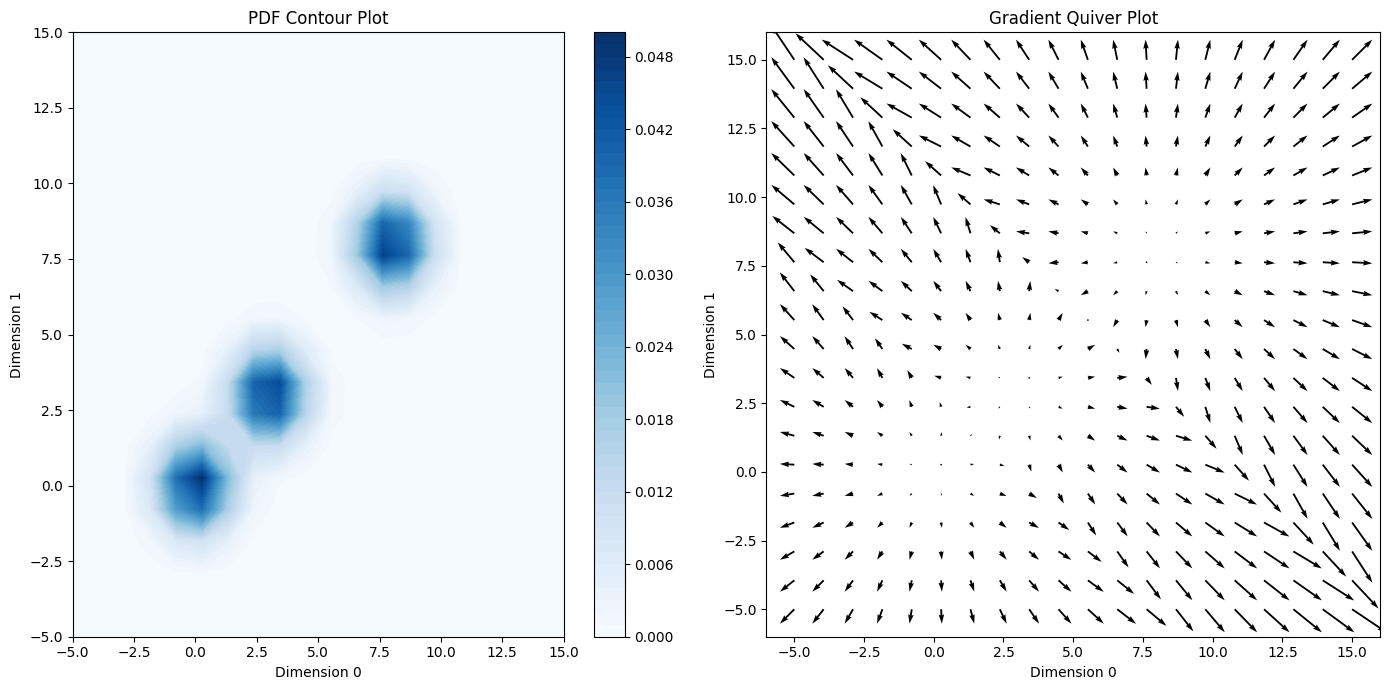

In [107]:

def create_2d_grid_and_evaluate(model, dim1, dim2, range1=(-5, 15), range2=(-5, 15), resolution=20):
    # Generate a grid of points in the two selected dimensions
    x = np.linspace(range1[0], range1[1], resolution)
    y = np.linspace(range2[0], range2[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    Z_pdf = np.zeros(X.shape)
    Z_dVdx = np.zeros(X.shape)
    Z_dVdy = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            point = np.zeros((len(mus[0]),))  # Assuming mus is accessible; adjust as needed
            point[dim1] = X[i, j]
            point[dim2] = Y[i, j]
            Z_pdf[i, j] = model.pdf(point)
            gradient = model.dVdx(point)
            Z_dVdx[i, j] = gradient[dim1]
            Z_dVdy[i, j] = -gradient[dim2]
    
    return X, Y, Z_pdf, Z_dVdx, Z_dVdy

# Example usage
dim1, dim2 = 0, 1  # Dimensions to visualize
X, Y, Z_pdf, Z_dVdx, Z_dVdy = create_2d_grid_and_evaluate(gmnd, dim1, dim2)

# Contour plot for PDF
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
contour = plt.contourf(X, Y, Z_pdf, levels=50, cmap='Blues')
plt.colorbar(contour)
plt.title('PDF Contour Plot')
plt.xlabel(f'Dimension {dim1}')
plt.ylabel(f'Dimension {dim2}')

# Quiver plot for Gradient
plt.subplot(1, 2, 2)
plt.quiver(X, Y, Z_dVdx, Z_dVdy)
plt.title('Gradient Quiver Plot')
plt.xlabel(f'Dimension {dim1}')
plt.ylabel(f'Dimension {dim2}')

plt.tight_layout()
plt.show()

In [82]:

def leapfrog(dVdx, x, v, h, N, M=None):
    """
    dVdx - a function returning the gradient of the potential energy with respect to position x
    x - initial position, could be a scalar or a numpy array for multivariate cases
    v - initial velocity, same dimensions as x
    h - step length
    N - number of steps
    M - mass matrix, optional; if None, identity is assumed
    """
    
    # Ensure x and v are numpy arrays for consistency
    x = np.asarray(x)
    v = np.asarray(v)
    
    if M is None:
        M_inv = np.identity(len(x)) if x.ndim > 0 else 1  # Identity if multivariate, or scalar 1 if 1D
    else:
        M_inv = np.linalg.inv(M)  # Inverse of the mass matrix
    
    trace_x = [x.copy()]
    trace_v = [v.copy()]

    # Update velocity by half step
    v = v - (h / 2) * dVdx(x)
    
    for _ in range(N-1):
        x = x + h * np.dot(M_inv, v)  # Update position by full step
        v = v - h * dVdx(x)           # Update velocity by full step
        trace_x.append(x.copy())
        trace_v.append(v.copy())

    x = x + h * np.dot(M_inv, v)
    v = v - (h / 2) * dVdx(x)  # Final half-step for velocity

    trace_x.append(x.copy())
    trace_v.append(v.copy())

    return np.array(trace_x), np.array(trace_v), x, v

def euler(dVdx, x, v, h, N, M=None):
    """
    Euler method for updating position and velocity in HMC.
    
    Parameters:
    - dVdx: Function returning the gradient of the potential energy with respect to position x.
    - x: Initial position, could be a scalar or a numpy array for multivariate cases.
    - v: Initial velocity, same dimensions as x.
    - h: Step length.
    - N: Number of steps.
    - M: Mass matrix, optional; if None, identity is assumed.
    """
    x = np.asarray(x)
    v = np.asarray(v)
    
    if M is None:
        M_inv = np.identity(len(x)) if x.ndim > 0 else 1  # Identity if multivariate, or scalar 1 if 1D
    else:
        M_inv = np.linalg.inv(M)
    
    trace_x = [x.copy()]
    trace_v = [v.copy()]

    for _ in range(N):
        x = x + h * np.dot(M_inv, v)  # Update position using current velocity
        v = v - h * dVdx(x)           # Update velocity using gradient at new position
        trace_x.append(x.copy())
        trace_v.append(v.copy())

    return np.array(trace_x), np.array(trace_v), x, v


def split_step(dVdx, x, v, h, N, b=0.2118, M=None):
    """
    Split-step method for updating position and velocity in HMC.
    
    Parameters:
    - dVdx: Function returning the gradient of the potential energy with respect to position x.
    - x: Initial position, could be a scalar or a numpy array for multivariate cases.
    - v: Initial velocity, same dimensions as x.
    - h: Step length.
    - N: Number of steps.
    - b: Parameter defining the fraction of the step for velocity updates in the split-step method.
        Important values: minimal error: 0.1932. An alernative is b = 0.2118
    - M: Mass matrix, optional; if None, identity is assumed.
    """
    x = np.asarray(x)
    v = np.asarray(v)
    
    if M is None:
        M_inv = np.identity(len(x)) if x.ndim > 0 else 1  # Identity if multivariate, or scalar 1 if 1D
    else:
        M_inv = np.linalg.inv(M)
    
    trace_x = [x.copy()]
    trace_v = [v.copy()]

    for _ in range(N):
        # First velocity update (kick)
        v = v - b * h * dVdx(x)
        
        # First position update (drift)
        x = x + (h / 2) * np.dot(M_inv, v)
        
        # Middle velocity update (kick)
        v = v - (1 - 2*b) * h * dVdx(x)
        
        # Second position update (drift)
        x = x + (h / 2) * np.dot(M_inv, v)
        
        # Last velocity update (kick)
        v = v - b * h * dVdx(x)
        
        trace_x.append(x.copy())
        trace_v.append(v.copy())

    return np.array(trace_x), np.array(trace_v), x, v


def hmc_nd(target_distribution, initial_state, iterations=10_000, step_size=0.1, n_steps=10, integrator='leapfrog'):
    """
    Adapted HMC for multidimensional target distributions.

    Parameters:
    - target_distribution: An object with .log_pdf(x) and .dVdx(x) methods.
    - initial_state: A numpy array representing the initial state in the parameter space.
    - iterations: Number of iterations to run the HMC sampler.
    - step_size: Step size (epsilon) for the leapfrog integrator.
    - n_steps: Number of leapfrog steps per HMC iteration.
    """
    samples = [initial_state]
    accept_or_not = []
    trace_x_all = []  # Will store arrays of x values for each accepted orbit
    trace_v_all = []  # Will store arrays of v values for each accepted orbit

    dVdx = target_distribution.dVdx  # Gradient of the log PDF

    for i in range(iterations):
        if i % 1000 == 0:
            print(f'Current iteration: {i}')

        x0 = samples[-1]
        v0 = np.random.normal(size=initial_state.shape)  # Match the dimensions of the initial state

        # Perform the leapfrog integration
        if integrator == 'leapfrog':
            trace_x, trace_v, x_star, v_star = leapfrog(dVdx, x0, v0, step_size, n_steps)
        elif integrator == 'euler':
            trace_x, trace_v, x_star, v_star = euler(dVdx, x0, v0, step_size, n_steps)
        elif integrator == 'splitstep':
            trace_x, trace_v, x_star, v_star = split_step(dVdx, x0, v0, step_size, n_steps)

        # Metropolis-Hastings step
        m0 = -target_distribution.log_pdf(x0) + 0.5 * np.sum(v0**2)
        m_star = -target_distribution.log_pdf(x_star) + 0.5 * np.sum(v_star**2)
        accept_prob = np.exp(m0 - m_star)

        if np.random.uniform() < accept_prob:
            samples.append(x_star)
            accept_or_not.append(True)  # Accepted
            trace_x_all.append(trace_x)
            trace_v_all.append(trace_v)
        else:
            samples.append(x0)
            accept_or_not.append(False)  # Not accepted

    samples = np.array(samples)
    return samples, trace_x_all, trace_v_all, accept_or_not


In [86]:
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]
sigmas = [np.eye(2), np.eye(2), np.eye(2)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array([0.0, 0.0])

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=10000,  # Adjust based on your computational budget
    step_size=0.1,
    n_steps=10,
    integrator='splitstep'
)

Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000


In [87]:
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]
sigmas = [np.eye(2), np.eye(2), np.eye(2)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array([0.0, 0.0])


step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    for _ in range(repeats):
        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=1000,  # Using fewer iterations for illustration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='splitstep'  # Assuming you have implemented a 'splitstep' integrator option
        )

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    mean_rate = np.mean(rates)
    std_dev = np.std(rates)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev:.3f}")

Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Step size 0.1: Mean acceptance rate = 1.000, Std dev = 0.001
Step size 0.5: Mean acceptance rate = 0.997, Std dev = 0.001
Step size 1.0: Mean acceptance rate = 

In [88]:
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]
sigmas = [np.eye(2), np.eye(2), np.eye(2)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array([0.0, 0.0])


step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    for _ in range(repeats):
        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=1000,  # Using fewer iterations for illustration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='leapfrog'  # Assuming you have implemented a 'splitstep' integrator option
        )

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    mean_rate = np.mean(rates)
    std_dev = np.std(rates)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev:.3f}")

Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0


C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:38: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:28: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(x))


Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Step size 0.1: Mean acceptance rate = 0.999, Std dev = 0.001
Step size 0.5: Mean acceptance rate = 0.969, Std dev = 0.004
Step size 1.0: Mean acceptance rate = 0.873, Std dev = 0.008
Step size 2.0: Mean acceptance rate = 0.013, Std dev = 0.004


In [89]:
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]
sigmas = [np.eye(2), np.eye(2), np.eye(2)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array([0.0, 0.0])


step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    for _ in range(repeats):
        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=1000,  # Using fewer iterations for illustration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='euler'  # Assuming you have implemented a 'splitstep' integrator option
        )

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    mean_rate = np.mean(rates)
    std_dev = np.std(rates)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev:.3f}")

Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0


C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:38: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:28: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(x))


Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Step size 0.1: Mean acceptance rate = 0.957, Std dev = 0.006
Step size 0.5: Mean acceptance rate = 0.795, Std dev = 0.010
Step size 1.0: Mean acceptance rate = 0.509, Std dev = 0.037
Step size 2.0: Mean acceptance rate = 0.006, Std dev = 0.003


In [90]:
import time

In [91]:
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]
sigmas = [np.eye(2), np.eye(2), np.eye(2)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array([0.0, 0.0])

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  # Store execution times

for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  # Start timing

        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=1000,  # Using fewer iterations for demonstration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='splitstep'  # Assuming 'splitstep' integrator is implemented
        )

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time)  # Store the execution time for this run

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates and times for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")


Running simulations for step size 0.1
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0
Current iteration: 0


KeyboardInterrupt: 

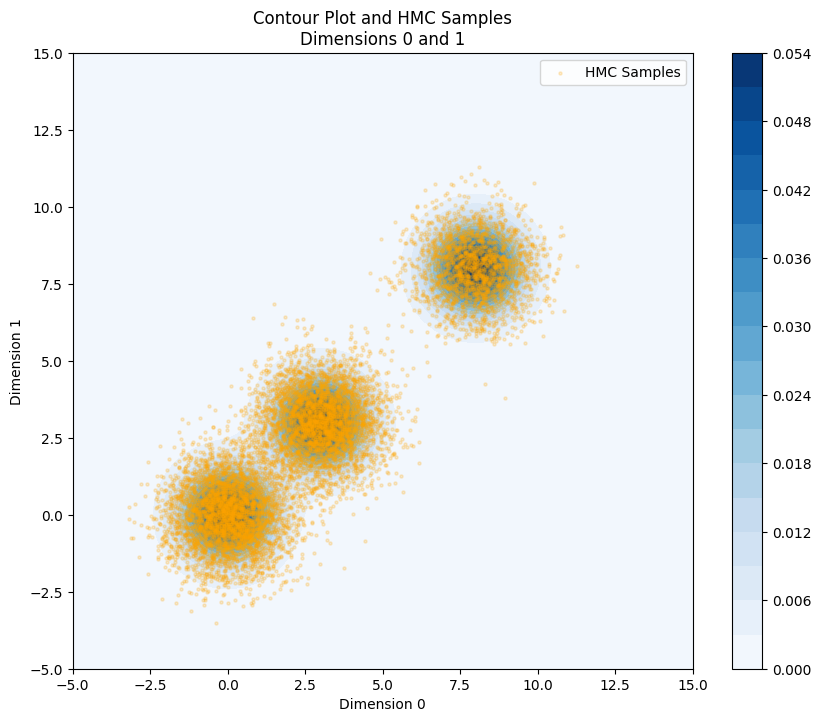

In [60]:
def plot_contour_and_samples_for_two_dims(gmnd, samples, dim1, dim2, x_range, y_range, resolution=100):
    """
    Plot a contour plot for two selected dimensions of the multivariate Gaussian mixture model
    and overlay HMC samples projected onto these two dimensions.
    
    Args:
    - gmnd: An instance of GaussianMultimodalND.
    - samples: An array of sampled points from HMC.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Prepare an array for evaluating the PDF
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            x_vector = np.zeros(len(gmnd.mus[0]))  # Assume all modes have the same dimensionality
            x_vector[dim1] = X[i, j]
            x_vector[dim2] = Y[i, j]
            # Here, you can fix other dimensions at their means or any other reference values
            Z[i, j] = gmnd.pdf(x_vector)
    
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='Blues')
    plt.colorbar(cp)
    plt.title(f'Contour Plot and HMC Samples\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    
    # Project HMC samples onto the two dimensions and plot
    sample_points_dim1 = samples[:, dim1]
    sample_points_dim2 = samples[:, dim2]
    plt.scatter(sample_points_dim1, sample_points_dim2, color='orange', s=5, alpha=0.2, label='HMC Samples')
    plt.legend()
    
    plt.show()

# Assuming `samples` is a numpy array of sampled points
# Convert list of samples to a numpy array for easy indexing
samples_array = np.array(samples[1:])  # Exclude the initial state if it's included
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 0, 1, (-5, 15), (-5, 15))

# High Dim Standard Normal

In [54]:
N = 100

mus = [np.zeros(N)+1]
sigmas = [np.eye(N)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array(np.zeros(N))

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=5000,  # Adjust based on your computational budget
    step_size=0.1,
    n_steps=10
)

Current iteration: 0


KeyboardInterrupt: 

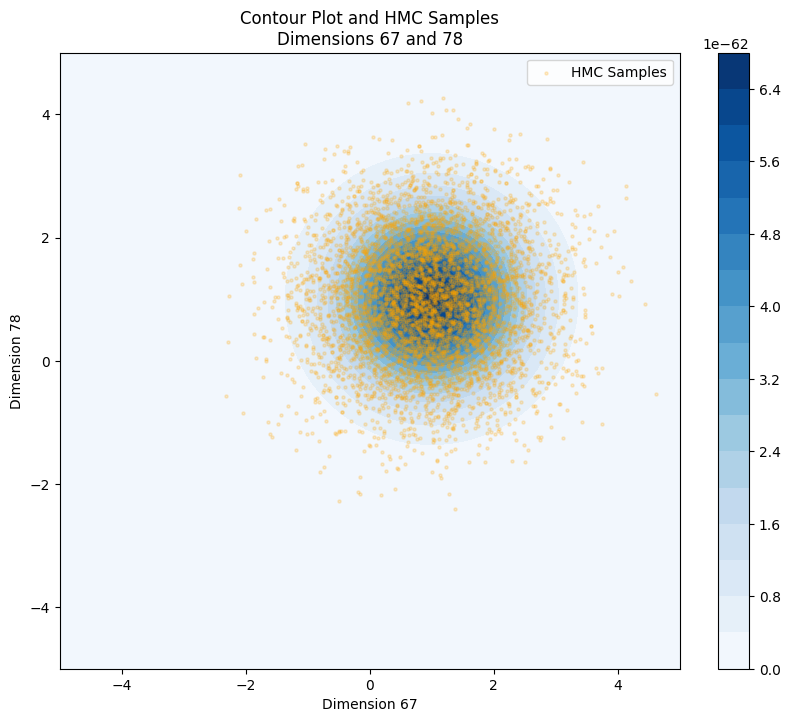

In [17]:
def plot_contour_and_samples_for_two_dims(gmnd, samples, dim1, dim2, x_range, y_range, resolution=100):
    """
    Plot a contour plot for two selected dimensions of the multivariate Gaussian mixture model
    and overlay HMC samples projected onto these two dimensions.
    
    Args:
    - gmnd: An instance of GaussianMultimodalND.
    - samples: An array of sampled points from HMC.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Prepare an array for evaluating the PDF
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            x_vector = np.zeros(len(gmnd.mus[0]))  # Assume all modes have the same dimensionality
            x_vector[dim1] = X[i, j]
            x_vector[dim2] = Y[i, j]
            # Here, you can fix other dimensions at their means or any other reference values
            Z[i, j] = gmnd.pdf(x_vector)
    
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='Blues')
    plt.colorbar(cp)
    plt.title(f'Contour Plot and HMC Samples\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    
    # Project HMC samples onto the two dimensions and plot
    sample_points_dim1 = samples[:, dim1]
    sample_points_dim2 = samples[:, dim2]
    plt.scatter(sample_points_dim1, sample_points_dim2, color='orange', s=5, alpha=0.2, label='HMC Samples')
    plt.legend()
    
    plt.show()


def plot_contour_and_samples_for_two_dims(gmnd, samples, dim1, dim2, x_range, y_range, resolution=100):
    """
    Plot a contour plot for two selected dimensions of the multivariate Gaussian mixture model
    and overlay HMC samples projected onto these two dimensions, using the marginalized PDF.
    
    Args:
    - gmnd: An instance of GaussianMultimodalND.
    - samples: An array of sampled points from HMC.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            # Directly use the marginalized_pdf method for the specified dimensions
            Z[i, j] = gmnd.marginalized_pdf([X[i, j], Y[i, j]], [dim1, dim2])
    
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(cp)
    plt.title(f'Contour Plot and HMC Samples\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    
    # Project HMC samples onto the two dimensions and plot
    sample_points_dim1 = samples[:, dim1]
    sample_points_dim2 = samples[:, dim2]
    plt.scatter(sample_points_dim1, sample_points_dim2, color='orange', s=5, alpha=0.6, label='HMC Samples')
    plt.legend()
    
    plt.show()

# Assuming `samples` is a numpy array of sampled points
# Convert list of samples to a numpy array for easy indexing
samples_array = np.array(samples[1:])  # Exclude the initial state if it's included
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 67, 78, (-5, 5), (-5, 5))

Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000


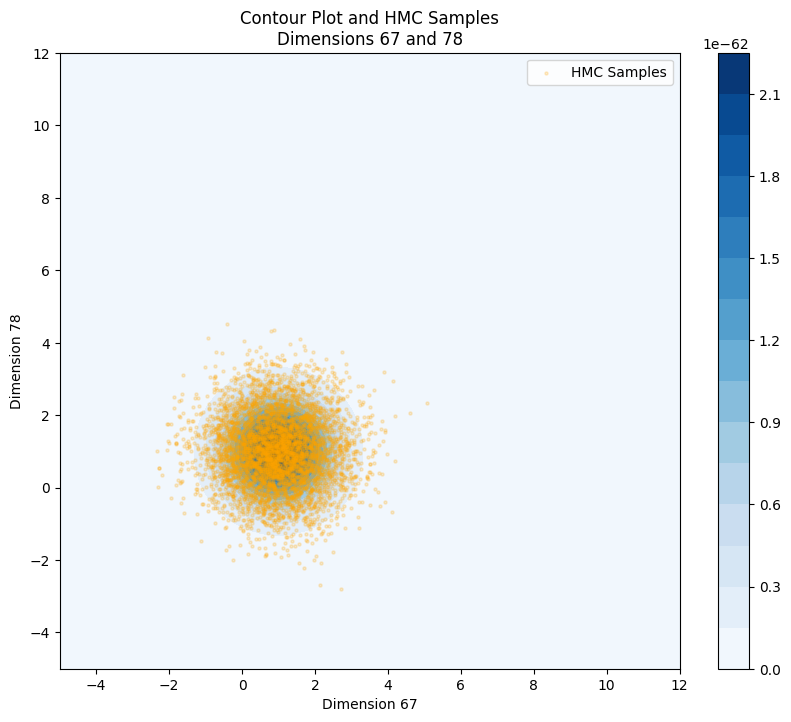

In [18]:
N = 100


mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [np.eye(N), np.eye(N), np.eye(N)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=5000,  # Adjust based on your computational budget
    step_size=0.1,
    n_steps=10
)

# Assuming `samples` is a numpy array of sampled points
# Convert list of samples to a numpy array for easy indexing
samples_array = np.array(samples[1:])  # Exclude the initial state if it's included
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 67, 78, (-5, 12), (-5, 12))

In [22]:
np.sum(accept_or_not)

4962

In [23]:
np.save('samples_N100_3means_questionmark.npy', samples_array)  
np.save('accept_or_not_N100_3means_questionmark.npy', accept_or_not)  

#loaded_samples_array = np.load('samples_array.npy')

In [141]:

def plot_contour_and_samples_for_two_dims(gmnd, samples, dim1, dim2, x_range, y_range, resolution=100):
    """
    Plot a contour plot for two selected dimensions of the multivariate Gaussian mixture model
    and overlay HMC samples projected onto these two dimensions, using the marginalized PDF.
    
    Args:
    - gmnd: An instance of GaussianMultimodalND.
    - samples: An array of sampled points from HMC.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            # Directly use the marginalized_pdf method for the specified dimensions
            Z[i, j] = gmnd.marginalized_pdf([X[i, j], Y[i, j]], [dim1, dim2])
    
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='Blues')
    plt.colorbar(cp)
    plt.title(f'Contour Plot and HMC Samples\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    
    # Project HMC samples onto the two dimensions and plot
    sample_points_dim1 = samples[:, dim1]
    sample_points_dim2 = samples[:, dim2]
    plt.scatter(sample_points_dim1, sample_points_dim2, color='orange', s=5, alpha=0.3, label='HMC Samples')
    plt.legend()
    
    plt.show()

In [35]:
def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix

N = 2
correlation_coefficient = 0.4  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=10000,  # Adjust based on your computational budget
    step_size=0.5,
    n_steps=10
)

# Assuming `samples` is a numpy array of sampled points
# Convert list of samples to a numpy array for easy indexing
samples_array = np.array(samples[1:])  # Exclude the initial state if it's included
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 0, 1, (-5, 12), (-5, 12))

Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000


KeyboardInterrupt: 

In [121]:
def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix

N = 2
correlation_coefficient = 0.0  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  # Store execution times

for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  # Start timing

        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=10000,  # Using fewer iterations for demonstration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='euler'  # Assuming 'splitstep' integrator is implemented
        )

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time)  # Store the execution time for this run

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates and times for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")

euler_ar = mean_rate
euler_ar_std = std_dev_rate


Running simulations for step size 0.1
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iterat

C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:38: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:28: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(x))


Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Curr

In [122]:
def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix

N = 2
correlation_coefficient = 0.0  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  # Store execution times

for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  # Start timing

        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=10000,  # Using fewer iterations for demonstration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='leapfrog'  # Assuming 'splitstep' integrator is implemented
        )

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time)  # Store the execution time for this run

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates and times for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")


leapfrog_ar = mean_rate
leapfrog_ar_std = std_dev_rate

Running simulations for step size 0.1
Current iteration: 0


Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Curr

C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:38: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:28: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(x))


Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Curr

In [123]:
def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix

N = 2
correlation_coefficient = 0.0  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  # Store execution times

for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  # Start timing

        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=10000,  # Using fewer iterations for demonstration; adjust as needed
            step_size=step_size,
            n_steps=10,
            integrator='splitstep'  # Assuming 'splitstep' integrator is implemented
        )

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time)  # Store the execution time for this run

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates and times for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")


splitstep_ar = mean_rate
splitstep_ar_std = std_dev_rate


Running simulations for step size 0.1
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Current iterat

In [151]:
def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix

N = 10
correlation_coefficient = 0.0  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
step_sizes = [2*h/3 for h in step_sizes]
n_steps = 15
repeats = 1  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  # Store execution times

for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  # Start timing

        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=10000,  # Using fewer iterations for demonstration; adjust as needed
            step_size=step_size,
            n_steps=n_steps,
            integrator='leapfrog'  # Assuming 'splitstep' integrator is implemented
        )

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time)  # Store the execution time for this run

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates and times for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")


leapfrog_adj_ar = mean_rate
leapfrog_adj_ar_std = std_dev_rate

Running simulations for step size 0.06666666666666667
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Running simulations for step size 0.3333333333333333
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Running simulations for step size 0.6666666666666666
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Running simulations for step size 1.3333333333333333
Current iteration: 0
Current iteration: 1000
Current iteration: 2000


C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:38: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
C:\Users\isacb\AppData\Local\Temp\ipykernel_20656\691469608.py:28: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(x))


Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Step size 0.06666666666666667: Mean acceptance rate = 0.999, Std dev = 0.000, Mean time = 301.165s, Std dev time = 0.000s
Step size 0.3333333333333333: Mean acceptance rate = 0.965, Std dev = 0.000, Mean time = 308.522s, Std dev time = 0.000s
Step size 0.6666666666666666: Mean acceptance rate = 0.901, Std dev = 0.000, Mean time = 277.409s, Std dev time = 0.000s
Step size 1.3333333333333333: Mean acceptance rate = 0.886, Std dev = 0.000, Mean time = 287.750s, Std dev time = 0.000s


In [150]:
def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix

N = 10
correlation_coefficient = 0.0  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
step_sizes = [h/3 for h in step_sizes]
n_steps = 30
repeats = 1  # Number of repeats for each step size

# Store overall results
overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  # Store execution times

for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  # Start timing

        # Run HMC sampling
        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=10000,  # Using fewer iterations for demonstration; adjust as needed
            step_size=step_size,
            n_steps=n_steps,
            integrator='euler'  # Assuming 'splitstep' integrator is implemented
        )

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time)  # Store the execution time for this run

        # Calculate and store the acceptance rate for this run
        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

# Calculate mean and standard deviation of acceptance rates and times for each step size
for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")


leapfrog_adj_ar = mean_rate
leapfrog_adj_ar_std = std_dev_rate
print('Euler h/3')

Running simulations for step size 0.03333333333333333
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Running simulations for step size 0.16666666666666666
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Running simulations for step size 0.3333333333333333
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000
Running simulations for step size 0.6666666666666666
Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Curren

Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000


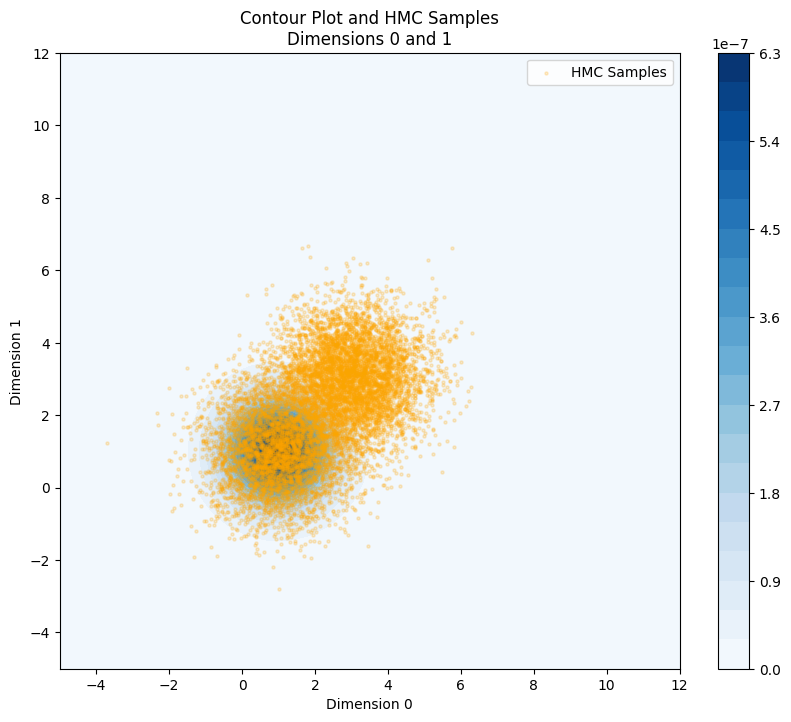

In [97]:
N = 10
mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=10000,  # Adjust based on your computational budget
    step_size=0.5,
    n_steps=10,
    integrator='splitstep'
)

# Assuming `samples` is a numpy array of sampled points
# Convert list of samples to a numpy array for easy indexing
samples_array = np.array(samples[1:])  # Exclude the initial state if it's included
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 0, 1, (-5, 12), (-5, 12))

In [ ]:
title = 'Acceptance Rate v Step Size, d = 10 \n averaged over 10 runs.'

x = [0.1, 0.5, 1.0, 2.0]

euler_ar = [0.886, 0.446, 0.065, 0.000]
euler_ar_std = [0.004, 0.004, 0.005, 0.000]

leapfrog_ar = [0.998, 0.925, 0.698, 0.000]
leapfrog_ar_std = [0.0, 0.002, 0.004, 0.000]

splitstep_ar = [1.000, 0.993, 0.984, 0.949]
splitstep_std = [0.000, 0.001, 0.001, 0.002]



In [144]:
N = 10
mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=10000, 
    step_size=0.5,
    n_steps=10,
    integrator='splitstep'
)

Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000


In [142]:

def plot_contour_and_samples_for_two_dims(gmnd, samples, dim1, dim2, x_range, y_range, resolution=100):
    """
    Plot a contour plot for two selected dimensions of the multivariate Gaussian mixture model
    and overlay HMC samples projected onto these two dimensions, using the marginalized PDF.
    
    Args:
    - gmnd: An instance of GaussianMultimodalND.
    - samples: An array of sampled points from HMC.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            # Directly use the marginalized_pdf method for the specified dimensions
            Z[i, j] = gmnd.marginalized_pdf([X[i, j], Y[i, j]], [dim1, dim2])
    
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='Blues')
    #plt.colorbar(cp)
    plt.title(f'Contour Plot and HMC Samples\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    
    # Project HMC samples onto the two dimensions and plot
    sample_points_dim1 = samples[:, dim1]
    sample_points_dim2 = samples[:, dim2]
    plt.scatter(sample_points_dim1, sample_points_dim2, color='orange', s=5, alpha=0.3, label='HMC Samples')
    plt.legend()
    
    plt.show()

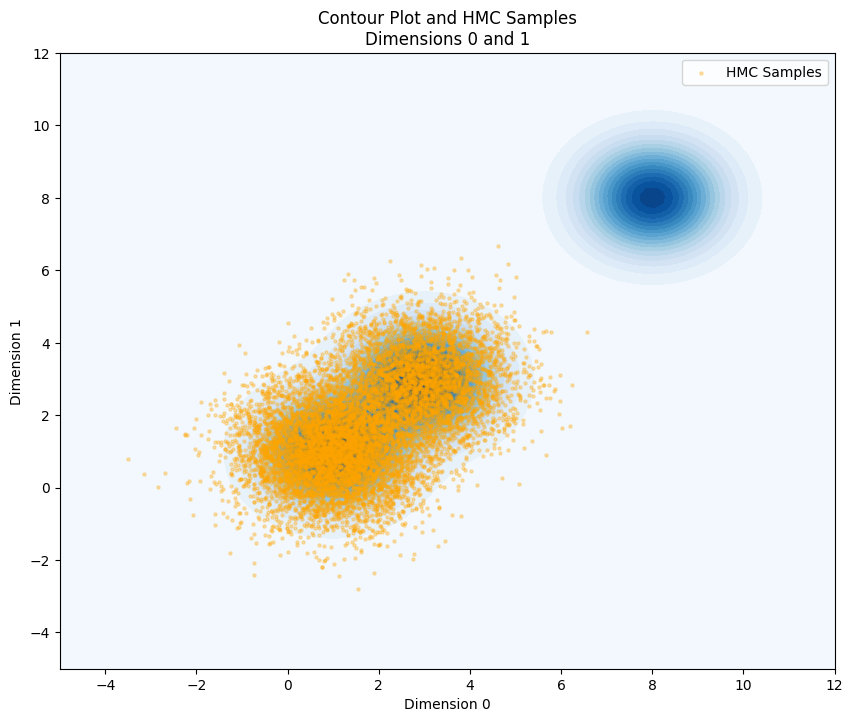

In [147]:
plot_contour_and_samples_for_two_dims(gmnd, samples, 1, 5, (-5, 12), (-5, 12))

Current iteration: 0
Current iteration: 1000
Current iteration: 2000
Current iteration: 3000
Current iteration: 4000
Current iteration: 5000
Current iteration: 6000
Current iteration: 7000
Current iteration: 8000
Current iteration: 9000


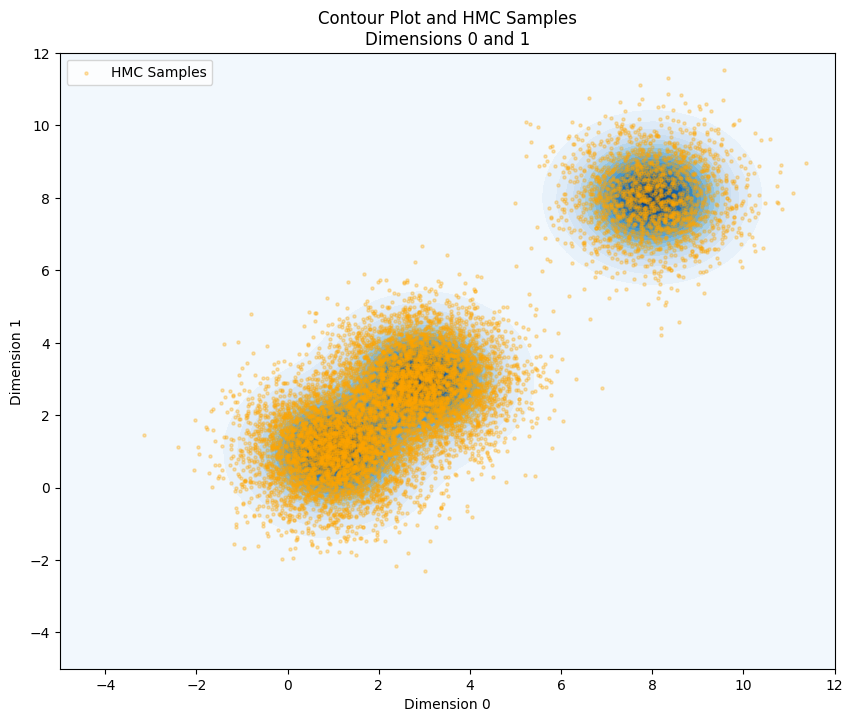

In [148]:
N = 2
mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd2 = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# Run HMC sampling
samples2, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd2,
    initial_state=initial_state,
    iterations=10000, 
    step_size=0.5,
    n_steps=10,
    integrator='splitstep'
)

plot_contour_and_samples_for_two_dims(gmnd2, samples2, 0, 1, (-5, 12), (-5, 12))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

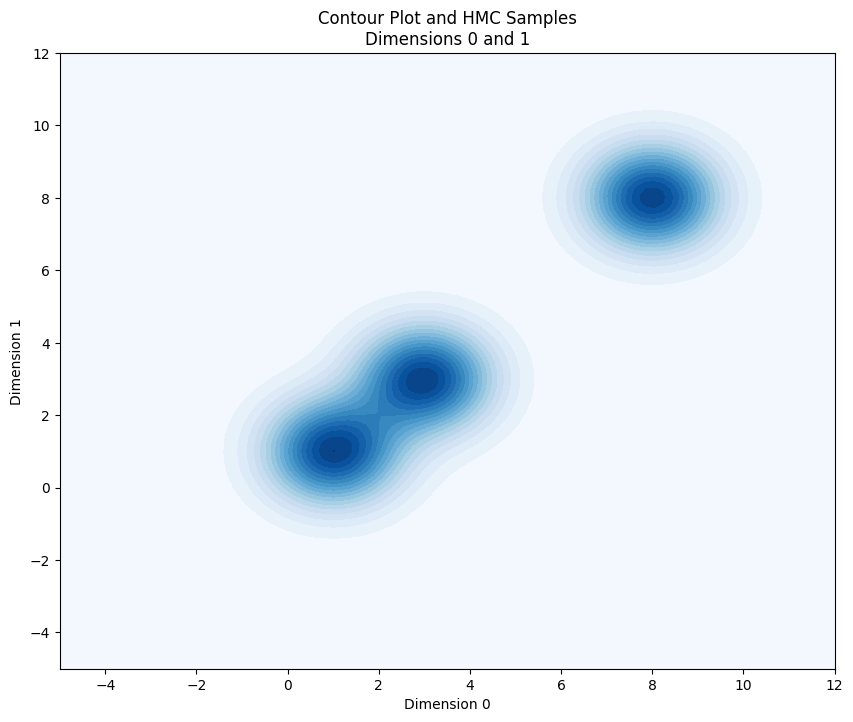

In [149]:
plot_contour_and_samples_for_two_dims(gmnd2, samples2[1], 0, 1, (-5, 12), (-5, 12))

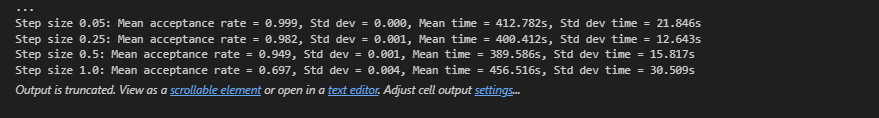

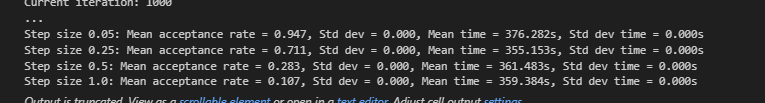

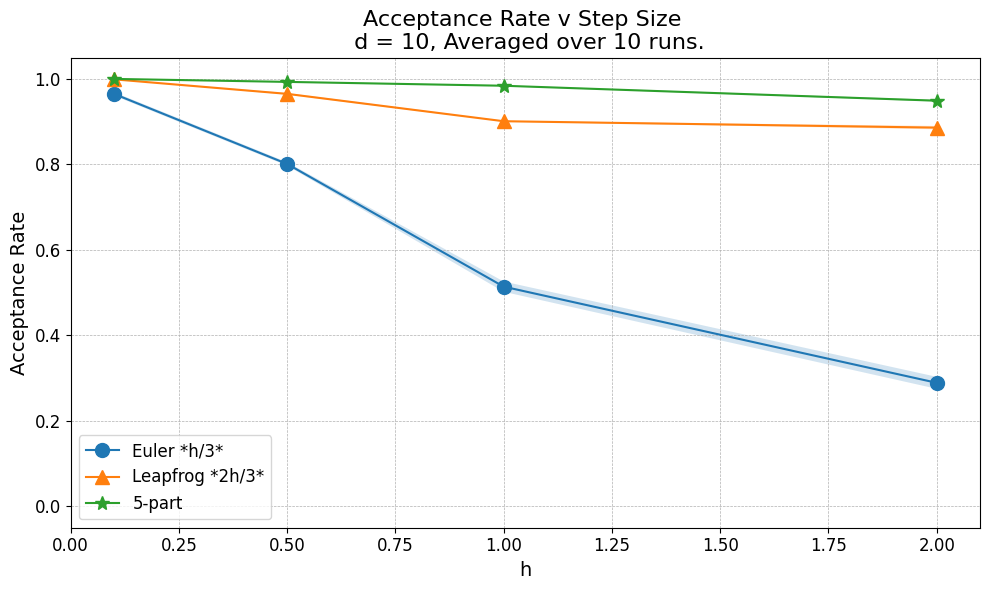

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Given data
title = 'Acceptance Rate v Step Size \n d = 10, Averaged over 10 runs.'
x = np.array([0.1, 0.5, 1.0, 2.0])

euler_ar = np.array([0.886, 0.446, 0.065, 0.000])
euler_ar_std = np.array([0.004, 0.004, 0.005, 0.000])

euler_adj_ar = np.array([0.947, 0.711, 0.283, 0.107])
euler_adj_ar_std = np.array([0.004, 0.004, 0.005, 0.008])

#h/3
euler_adj_ar = np.array([0.965, 0.801, 0.514, 0.289])
euler_adj_ar_std = np.array([0.004, 0.004, 0.012, 0.014])


leapfrog_ar = np.array([0.998, 0.925, 0.698, 0.000])
leapfrog_ar_std = np.array([0.0, 0.002, 0.004, 0.000])

# h/2
leapfrog_adj_ar = np.array([0.999, 0.982, 0.949, 0.697])
leapfrog_adj_ar_std = np.array([0.0, 0.002, 0.001, 0.004])

# 2h/3
leapfrog_adj_ar = np.array([0.999, 0.965, 0.901, 0.886])
leapfrog_adj_ar_std = np.array([0.0, 0.002, 0.001, 0.004])

splitstep_ar = np.array([1.000, 0.993, 0.984, 0.949])
splitstep_std = np.array([0.000, 0.001, 0.001, 0.002])

# Plotting with bands and customizations
plt.figure(figsize=(10, 6))

# Custom marker size
marker_size = 10

euler_ar = euler_adj_ar
euler_ar_std = euler_adj_ar_std

leapfrog_ar = leapfrog_adj_ar
leapfrog_ar_std = leapfrog_adj_ar_std



# Euler
plt.plot(x, euler_ar, label='Euler *h/3*', marker='o', linestyle='-', markersize=marker_size)
plt.fill_between(x, euler_ar - euler_ar_std, euler_ar + euler_ar_std, alpha=0.2)

# Leapfrog
plt.plot(x, leapfrog_ar, label='Leapfrog *2h/3*', marker='^', linestyle='-', markersize=marker_size)
plt.fill_between(x, leapfrog_ar - leapfrog_ar_std, leapfrog_ar + leapfrog_ar_std, alpha=0.2)

# Split-step
plt.plot(x, splitstep_ar, label='5-part', marker='*', linestyle='-', markersize=marker_size)
plt.fill_between(x, splitstep_ar - splitstep_std, splitstep_ar + splitstep_std, alpha=0.2)

plt.title(title, fontsize=16)
plt.xlabel('h', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjusting the legend
plt.legend(fontsize=12)

# Setting limits and enabling grid
plt.xlim([0, 2.1])
plt.ylim([-0.05, 1.05])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

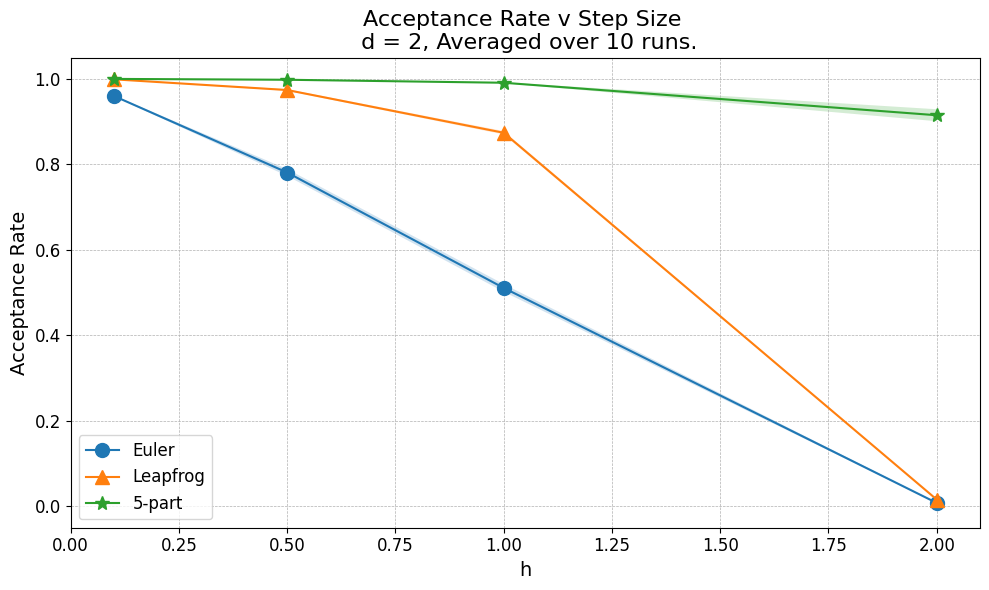

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Given data
title = 'Acceptance Rate v Step Size \n d = 2, Averaged over 10 runs.'
x = np.array([0.1, 0.5, 1.0, 2.0])

euler_ar = np.array([0.960, 0.781, 0.511, 0.008])
euler_ar_std = np.array([0.001, 0.008, 0.009, 0.001])

leapfrog_ar = np.array([0.999, 0.974, 0.874, 0.016])
leapfrog_ar_std = np.array([0.0, 0.002, 0.004, 0.001])

leapfrog_adj_ar = np.array([0.999, 0.974, 0.874, 0.016])
leapfrog_adj_ar_std = np.array([0.0, 0.002, 0.004, 0.001])

splitstep_ar = np.array([1.000, 0.998, 0.991, 0.915])
splitstep_std = np.array([0.000, 0.000, 0.001, 0.014])

# Plotting with bands and customizations
plt.figure(figsize=(10, 6))

# Custom marker size
marker_size = 10

"""
euler_ar = euler_adj_ar
euler_ar_std = euler_adj_ar_std

leapfrog_ar = leapfrog_adj_ar
leapfrog_ar_std = leapfrog_adj_ar_std
"""


# Euler
plt.plot(x, euler_ar, label='Euler', marker='o', linestyle='-', markersize=marker_size)
plt.fill_between(x, euler_ar - euler_ar_std, euler_ar + euler_ar_std, alpha=0.2)

# Leapfrog
plt.plot(x, leapfrog_ar, label='Leapfrog', marker='^', linestyle='-', markersize=marker_size)
plt.fill_between(x, leapfrog_ar - leapfrog_ar_std, leapfrog_ar + leapfrog_ar_std, alpha=0.2)

# Split-step
plt.plot(x, splitstep_ar, label='5-part', marker='*', linestyle='-', markersize=marker_size)
plt.fill_between(x, splitstep_ar - splitstep_std, splitstep_ar + splitstep_std, alpha=0.2)

plt.title(title, fontsize=16)
plt.xlabel('h', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjusting the legend
plt.legend(fontsize=12)

# Setting limits and enabling grid
plt.xlim([0, 2.1])
plt.ylim([-0.05, 1.05])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

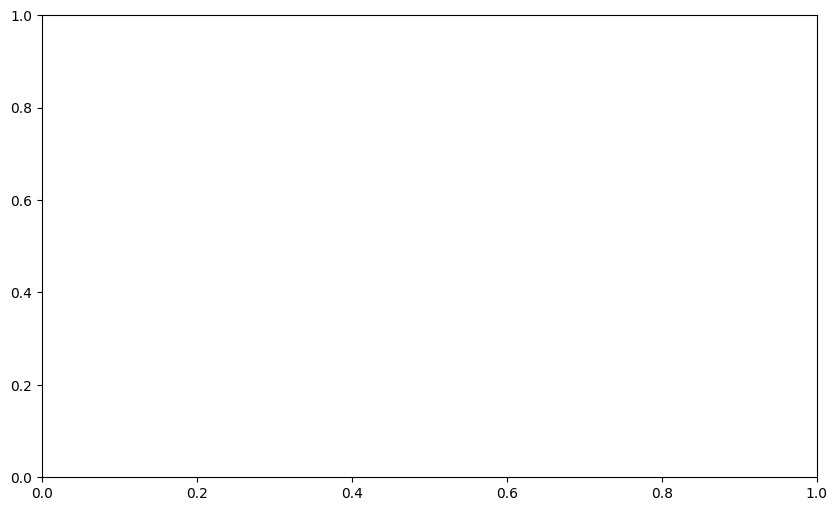

In [124]:
import matplotlib.pyplot as plt
import numpy as np
a
# Given data
title = 'Acceptance Rate v Step Size \n d = 2, Averaged over 10 runs.'
x = np.array([0.1, 0.5, 1.0, 2.0])

plt.figure(figsize=(10, 6))

# Custom marker size
marker_size = 8

# Euler
plt.plot(x, euler_ar, label='Euler', marker='o', linestyle='-', markersize=marker_size)
plt.fill_between(x, euler_ar - euler_ar_std, euler_ar + euler_ar_std, alpha=0.2)

# Leapfrog
plt.plot(x, leapfrog_ar, label='Leapfrog', marker='^', linestyle='-', markersize=marker_size)
plt.fill_between(x, leapfrog_ar - leapfrog_ar_std, leapfrog_ar + leapfrog_ar_std, alpha=0.2)

# Split-step
plt.plot(x, splitstep_ar, label='Split-step', marker='*', linestyle='-', markersize=marker_size)
plt.fill_between(x, splitstep_ar - splitstep_std, splitstep_ar + splitstep_std, alpha=0.2)

plt.title(title, fontsize=16)
plt.xlabel('Step Size', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjusting the legend
plt.legend(fontsize=12)

# Setting limits and enabling grid
plt.xlim([0, 2])
plt.ylim([0, 1])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

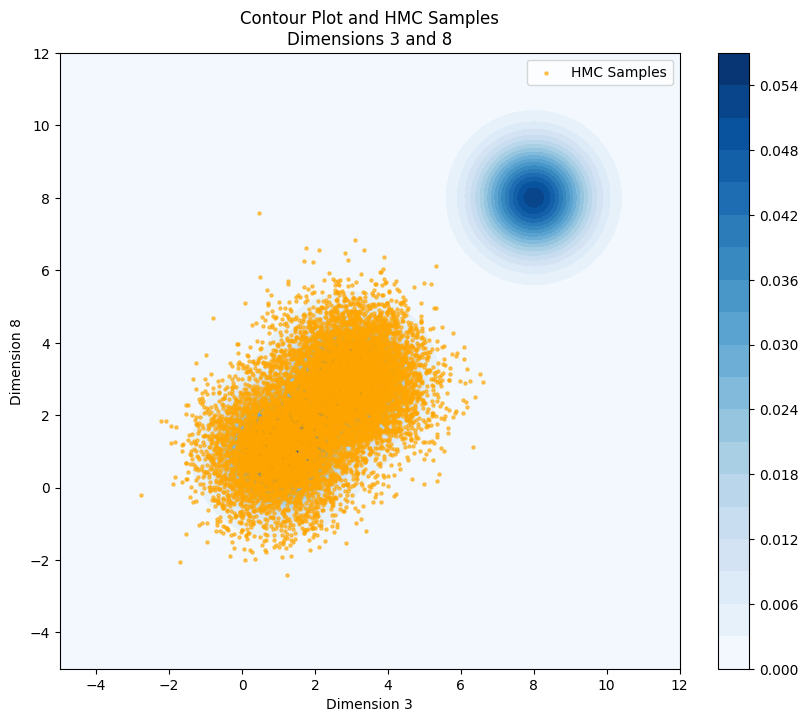

In [110]:
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 3, 8, (-5, 12), (-5, 12))

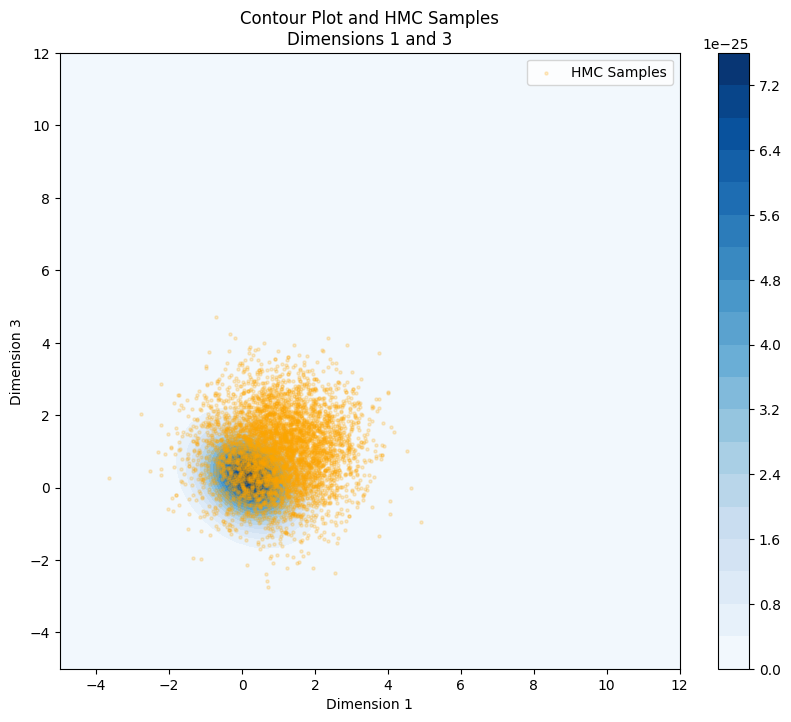

In [34]:
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 1, 3, (-5, 12), (-5, 12))

In [35]:
np.sum(accept_or_not)

4933

In [30]:
np.save('samples_N50w_3means.npy', samples_array)  
np.save('accept_or_notw_N50_3means.npy', accept_or_not)  

#loaded_samples_array = np.load('samples_array.npy')

KL Div

In [68]:
samples_array

array([[ 3.5687485 ,  3.67636477],
       [-0.22354239,  0.12956958],
       [ 3.77379659,  4.6165072 ],
       ...,
       [ 4.7778733 ,  3.21469703],
       [ 0.70155098, -0.30099889],
       [ 3.93435856,  2.66135463]])

In [9]:
import theano

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\Users\isacb\AppData\Roaming\Python\Python39\site-packages\theano\scalar\basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [15]:
pip install --upgrade theano

     ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
     --------------- ------------------------ 1.1/2.8 MB 22.7 MB/s eta 0:00:01
     ---------------------------------------- 2.8/2.8 MB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668148 sha256=ad9af669c6ae3586313bae8471d88024bf9a83152ae9cd3b0944a7091dc16ed7
  Stored in directory: c:\users\isacb\appdata\local\pip\cache\wheels\12\d8\36\e9b7c617ca8be398dcc48621c539d0cb1d41ff04e4367fc235
Successfully built theano
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pymc3 as pm

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [28]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

# Assuming 'samples_array' is your array of HMC samples with shape (num_samples, N)

n_modes = 3  # Number of components in the mixture model
N = 2  # Dimensionality of each sample

with pm.Model() as model:
    weights = pm.Dirichlet('weights', a=np.ones(n_modes))
    
    # Multivariate means
    means = pm.Normal('means', mu=0, sigma=10, shape=(n_modes, N))
    
    # Diagonal covariance for simplicity
    sd = pm.HalfNormal('sd', sigma=10, shape=(N,))
    
    # Constructing a list of component distributions
    components = []
    for i in range(n_modes):
        # Using the same diagonal covariance for each component for simplicity
        cov = tt.nlinalg.diag(sd**2)
        component_dist = pm.MvNormal.dist(mu=means[i], cov=cov)
        components.append(component_dist)
    
    # Mixture Model
    obs = pm.Mixture('obs', w=weights, comp_dists=components, observed=samples_array)
    
    trace = pm.sample(100, return_inferencedata=True, cores=1)

C:\Users\isacb\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\isacb\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\isacb\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\isacb\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, weights]


c:\Users\isacb\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\isacb\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 27 tune and 0 draw iterations (27 + 0 draws total) took 163 seconds.
No posterior samples. Unable to run convergence checks


In [32]:
from sklearn.mixture import GaussianMixture

gm  = GaussianMixture(n_components=3, random_state=1).fit(samples_array)

In [34]:
samples_array

array([[-9.39509055e-01, -1.03963984e+00],
       [-2.02707393e-01,  2.37345456e-01],
       [ 1.54276160e+00,  3.22414798e-01],
       [-7.15285784e-01, -9.07639708e-01],
       [ 1.42983427e+00,  3.38059361e-01],
       [ 9.99252747e-01, -6.03795013e-01],
       [-3.51460892e-01,  2.62127910e-01],
       [ 1.35593764e+00, -7.21095917e-02],
       [ 1.18438046e+00,  1.33932299e+00],
       [ 1.53568160e+00, -4.62350526e-01],
       [-3.29923856e-01,  1.21349799e+00],
       [ 2.30622587e+00, -8.63301870e-01],
       [-2.49193308e-01,  1.74921325e-01],
       [-1.21488716e+00,  2.37927063e-01],
       [ 6.58674144e-01, -1.97269910e-01],
       [ 3.58938015e-01,  7.26579855e-01],
       [-8.79516106e-02, -3.35928554e-02],
       [-7.58740402e-01, -1.44020905e+00],
       [-1.08257131e+00,  1.99356209e+00],
       [-5.60250369e-01,  1.34547014e+00],
       [-6.63460697e-01, -1.47981380e+00],
       [ 4.17578883e-01, -6.55857803e-01],
       [-1.38547795e+00, -7.29297860e-01],
       [-1.

In [26]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

#samples_array = ...  # Your samples, shape (num_samples, num_dimensions)
n_modes = 3  # For example

with pm.Model() as model:
    # Priors for the mixture weights
    weights = pm.Dirichlet('weights', a=np.ones(n_modes))
    
    # Priors for the component means and covariances
    means = pm.Normal('means', mu=0, sigma=10, shape=(n_modes, samples_array.shape[1]), testval=samples_array.mean(axis=0))
    sd = pm.HalfNormal('sd', sigma=5, shape=(n_modes, samples_array.shape[1]))
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=samples_array.shape[1], eta=2., sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True, shape=(n_modes, samples_array.shape[1] * (samples_array.shape[1] + 1) // 2))
    
    # Component distributions
    components = []
    for i in range(n_modes):
        cov = pm.math.dot(chol[i], chol[i].T)
        component_dist = pm.MvNormal.dist(mu=means[i], chol=cov)
        components.append(component_dist)
    
    # Mixture Model
    obs = pm.Mixture('obs', w=weights, comp_dists=components, observed=samples_array)
    
    # Sampling
    #trace = pm.sample(1000, return_inferencedata=True, target_accept=0.9)

C:\Users\isacb\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

# Numba

In [89]:
import numpy as np
import numba

@numba.jit(nopython=True)
def normal_distribution(x, mu, sigma):
    d = mu.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(sigma_det))
    x_mu = x - mu
    result = np.exp(-0.5 * np.dot(x_mu.T, np.dot(sigma_inv, x_mu)))
    return norm_const * result

@numba.jit(nopython=True)
def log_pdf(x, mus, sigmas, weights):
    pdf_val = 0.0
    for i in range(len(mus)):
        pdf_val += weights[i] * normal_distribution(x, mus[i], sigmas[i])
    return np.log(pdf_val)

@numba.jit(nopython=True)
def gradient_log_pdf(x, mus, sigmas, weights):
    numerator = np.zeros(x.shape)
    denominator = 0.0
    for i in range(len(mus)):
        weight = weights[i]
        mu = mus[i]
        sigma = sigmas[i]
        sigma_inv = np.linalg.inv(sigma)
        normal_val = normal_distribution(x, mu, sigma)
        numerator += weight * normal_val * -np.dot(sigma_inv, x - mu)
        denominator += weight * normal_val
    return numerator / denominator

@numba.jit(nopython=True)
def dVdx(x, mus, sigmas, weights):
    return -gradient_log_pdf(x, mus, sigmas, weights)



@numba.jit(nopython=True)
def leapfrog(x, v, h, N,  mus, sigmas, weights, M=None):
    """
    dVdx - a function returning the gradient of the potential energy with respect to position x
    x - initial position, could be a scalar or a numpy array for multivariate cases
    v - initial velocity, same dimensions as x
    h - step length
    N - number of steps
    M - mass matrix, optional; if None, identity is assumed
    """
    
    # Ensure x and v are numpy arrays for consistency
    x = np.asarray(x)
    v = np.asarray(v)
    
    if M is None:
        M_inv = np.identity(len(x)) if x.ndim > 0 else 1  # Identity if multivariate, or scalar 1 if 1D
    else:
        M_inv = np.linalg.inv(M)  # Inverse of the mass matrix
    
    trace_x = [x.copy()]
    trace_v = [v.copy()]

    # Update velocity by half step
    v = v - (h / 2) * dVdx(x)
    
    for _ in range(N-1):
        x = x + h * np.dot(M_inv, v)  # Update position by full step
        v = v - h * dVdx(x)           # Update velocity by full step
        trace_x.append(x.copy())
        trace_v.append(v.copy())

    x = x + h * np.dot(M_inv, v)
    v = v - (h / 2) * dVdx(x)  # Final half-step for velocity

    trace_x.append(x.copy())
    trace_v.append(v.copy())

    return np.array(trace_x), np.array(trace_v), x, v

@numba.jit(nopython=True)
def hmc_nd(mus, sigmas, initial_state, iterations=10_000, step_size=0.1, n_steps=10):
    """
    Adapted HMC for multidimensional target distributions.

    Parameters:
    - target_distribution: An object with .log_pdf(x) and .dVdx(x) methods.
    - initial_state: A numpy array representing the initial state in the parameter space.
    - iterations: Number of iterations to run the HMC sampler.
    - step_size: Step size (epsilon) for the leapfrog integrator.
    - n_steps: Number of leapfrog steps per HMC iteration.
    """
    samples = [initial_state]
    accept_or_not = []
    trace_x_all = []  # Will store arrays of x values for each accepted orbit
    trace_v_all = []  # Will store arrays of v values for each accepted orbit

    weights = np.ones(len(mus))/len(mus)
    #dVdx = lambda x: dVdx(x, mus, sigmas, weights) # Gradient of the log PDF

    for i in range(iterations):
        if i % 1000 == 0:
            print(f'Current iteration: {i}')

        x0 = samples[-1]
        v0 = np.random.normal(size=initial_state.shape)  # Match the dimensions of the initial state

        # Perform the leapfrog integration
        trace_x, trace_v, x_star, v_star = leapfrog(x0, v0, step_size, n_steps)# dVdx

        # Metropolis-Hastings step
        m0 = -log_pdf(x0, mus, sigmas, weights)  + 0.5 * np.sum(v0**2)
        m_star = -log_pdf(x_star, mus, sigmas, weights)  + 0.5 * np.sum(v_star**2)
        accept_prob = np.exp(m0 - m_star)

        if np.random.uniform() < accept_prob:
            samples.append(x_star)
            accept_or_not.append(True)  # Accepted
            trace_x_all.append(trace_x)
            trace_v_all.append(trace_v)
        else:
            samples.append(x0)
            accept_or_not.append(False)  # Not accepted

    samples = np.array(samples)
    return samples, trace_x_all, trace_v_all, accept_or_not


In [90]:
mus = [np.array([0, 0]), np.array([3, 3]), np.array([8, 8])]
sigmas = [np.eye(2), np.eye(2), np.eye(2)]
gmnd = GaussianMultimodalND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.array([0.0, 0.0])

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    mus=mus,
    sigmas=sigmas,
    initial_state=initial_state,
    iterations=1000,  # Adjust based on your computational budget
    step_size=0.1,
    n_steps=10
)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x0000024B29251940>) found for signature:
 
 >>> normal(size=UniTuple(int64 x 1))
 
There are 8 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'np_gauss_impl0': File: numba\cpython\randomimpl.py: Line 288.
        With argument(s): '(size=UniTuple(int64 x 1))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1mgot an unexpected keyword argument 'size'[0m[0m
  raised from c:\Users\isacb\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\core\typing\templates.py:784
[1m      - Of which 6 did not match due to:
      Overload in function 'np_gauss_impl1': File: numba\cpython\randomimpl.py: Line 294.
        With argument(s): '(size=UniTuple(int64 x 1))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1mmissing a required argument: 'loc'[0m[0m
  raised from c:\Users\isacb\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\core\typing\templates.py:784
[0m
[0m[1mDuring: resolving callee type: Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x0000024B29251940>)[0m
[0m[1mDuring: typing of call at C:\Users\isacb\AppData\Local\Temp\ipykernel_32368\1034589514.py (106)
[0m
[1m
File "..\..\..\Users\isacb\AppData\Local\Temp\ipykernel_32368\1034589514.py", line 106:[0m
[1m<source missing, REPL/exec in use?>[0m
